In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("insurance_cleaned_addcols.csv")
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,age_car_incident,age_policy_incident,workshop,adjuster
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,MALE,MD,craft-repair,sleeping,husband,53300,0,2015-01-25,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,9935 4th Drive,5,1,1,1,2,1,71610,6510,13020,52080,Saab,92x,2004,1,11,1,A,Frank
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,MALE,MD,machine-op-inspct,reading,other-relative,0,0,2015-01-21,Vehicle Theft,Front Collision,Minor Damage,Police,VA,Riverwood,6608 MLK Hwy,8,1,1,0,0,1,5070,780,780,3510,Mercedes,E400,2007,1,8,9,A,Frank
2,134,29,687698,2000-06-09,OH,100/300,2000,1413.14,5000000,430632,FEMALE,PhD,sales,board-games,own-child,35100,0,2015-02-22,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7121 Francis Lane,7,3,0,2,3,0,34650,7700,3850,23100,Dodge,RAM,2007,0,8,15,A,Frank
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,FEMALE,PhD,armed-forces,board-games,unmarried,48900,-62400,2015-10-01,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,6956 Maple Drive,5,1,0,1,2,0,63400,6340,6340,50720,Chevrolet,Tahoe,2014,1,1,25,C,Harry
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,MALE,Associate,sales,board-games,unmarried,66000,-46000,2015-02-17,Vehicle Theft,Front Collision,Minor Damage,None,NY,Arlington,3041 3rd Ave,20,1,0,0,1,0,6500,1300,650,4550,Accura,RSX,2009,0,6,1,C,Harry


### Separating numerical data and categorical data

In [3]:
non_numerical_cols = []
numerical_cols = []
for col in df.columns:
    if (df[col].dtype != np.int64 and df[col].dtype != np.float64):
        non_numerical_cols.append(col)
    else:
        numerical_cols.append(col)
numerical_cols.append('policy_bind_date')
categorical = df[non_numerical_cols[1:]]
numerical_cols.remove('fraud_reported')
numerical = df[numerical_cols].copy()
new_categorical = categorical.copy()

date_str_to_num = lambda string: (int(string[:4]) - 1990) + int(string[5:7])/12 + int(string[-2:])/(12 * 30)
for i in range(1000):
    numerical['policy_bind_date'][i] = date_str_to_num(df['policy_bind_date'][i])
for col in categorical.columns:
    uniques = categorical[col].unique()
    new_col = []
    for i in range(1000):
        n = len(uniques)
        for j in range(n):
            if (categorical[col][i] == uniques[j]):
                new_col.append(j)
                break
    new_categorical[col] = new_col
categorical = new_categorical
numerical = numerical/numerical.mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [4]:
array = np.zeros((1000,categorical.max().sum() + len(categorical.columns)))
index = 0
def oneHot(val, maxVal):
    output = [0]*maxVal
    output[val] = 1
    return output
for col in categorical.columns:
    num = categorical[col].max() + 1
    arr = np.zeros((1000,num))
    for i in range(1000):
        arr[i] = oneHot(categorical[col][i], num)
    array[:, index:index+num] = arr
    index += num

lst = [i for i in range(1000)]
np.random.shuffle(lst)

X_numerical_train = []
X_categorical_train = []
Y_train = []

for i in lst[:800]:
  X_numerical_train.append(numerical.iloc[i])
  X_categorical_train.append(array[i])
  Y_train.append(df['fraud_reported'].iloc[i])

X_numerical_val = []
X_categorical_val = []
Y_val = []
for i in lst[800:900]:
  X_numerical_val.append(numerical.iloc[i])
  X_categorical_val.append(array[i])
  Y_val.append(df['fraud_reported'].iloc[i])

X_numerical_test = []
X_categorical_test = []
Y_test = []
for i in lst[900:]:
  X_numerical_test.append(numerical.iloc[i])
  X_categorical_test.append(array[i])
  Y_test.append(df['fraud_reported'].iloc[i])

### Simple dense model for comparison
Typically ends with val_accuracy = 0.79

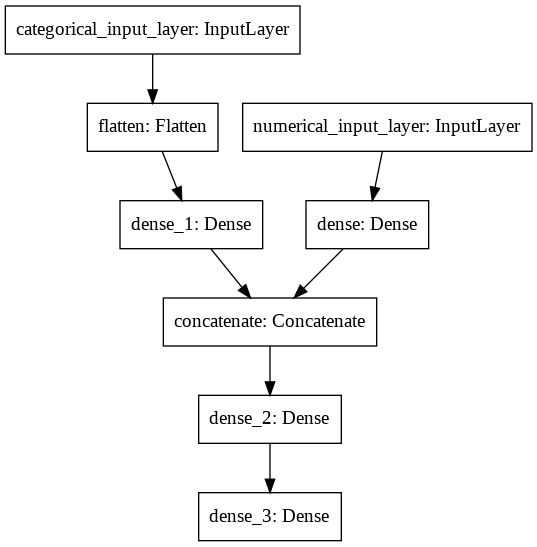

In [5]:
inputs_numerical = keras.Input(shape=(len(numerical_cols)), name = 'numerical_input_layer')
dense_numerical = layers.Dense(30, activation='relu')(inputs_numerical)


inputs_categorical = keras.Input(shape=(array.shape[1]), name = 'categorical_input_layer')
flatten_categorical = layers.Flatten()(inputs_categorical)
dense_categorical = layers.Dense(30, activation='relu')(flatten_categorical)

flatten_combined = layers.Concatenate()([dense_numerical, dense_categorical])
dense_combined = layers.Dense(30, activation='relu')(flatten_combined)
outputs = layers.Dense(1, activation='sigmoid')(dense_combined)
model = keras.Model(inputs=[inputs_numerical, inputs_categorical], outputs=outputs)

model.compile(optimizer="Adam", loss="binary_crossentropy",metrics = ['accuracy'])

keras.utils.plot_model(model)

In [6]:
bestValLoss = keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=15, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
    )


hist = model.fit(x = [np.array(X_numerical_train).astype(float), np.array(X_categorical_train)], 
                 y = np.array(Y_train),
                 validation_data = ([np.array(X_numerical_val).astype(float), np.array(X_categorical_val)], np.array(Y_val)),
                 epochs=1000, 
                 validation_split = 0.1,
                 callbacks = [bestValLoss],
                )
results = pd.DataFrame(hist.history)
results.to_csv('results.csv')
model.save("bestValLoss.hdf5")

Epoch 1/1000
23/23 [==============================] - 1s 20ms/step - loss: 0.6920 - accuracy: 0.5436 - val_loss: 0.4719 - val_accuracy: 0.8375
Epoch 2/1000
23/23 [==============================] - 0s 4ms/step - loss: 0.5332 - accuracy: 0.7733 - val_loss: 0.4682 - val_accuracy: 0.8375
Epoch 3/1000
23/23 [==============================] - 0s 4ms/step - loss: 0.5247 - accuracy: 0.7643 - val_loss: 0.4498 - val_accuracy: 0.8375
Epoch 4/1000
23/23 [==============================] - 0s 4ms/step - loss: 0.5248 - accuracy: 0.7292 - val_loss: 0.4146 - val_accuracy: 0.8375
Epoch 5/1000
23/23 [==============================] - 0s 4ms/step - loss: 0.4345 - accuracy: 0.7666 - val_loss: 0.3926 - val_accuracy: 0.7750
Epoch 6/1000
23/23 [==============================] - 0s 4ms/step - loss: 0.3735 - accuracy: 0.8466 - val_loss: 0.3596 - val_accuracy: 0.7750
Epoch 7/1000
23/23 [==============================] - 0s 4ms/step - loss: 0.2736 - accuracy: 0.8941 - val_loss: 0.3757 - val_accuracy: 0.8000
Epoch

### Results
Poor AUC and inconsistent run to run results!
43 variables with only 1000 datapoints make it difficult to run traditional ML methods like dense neural networks without overfitting

Plotting results created following guide on https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/

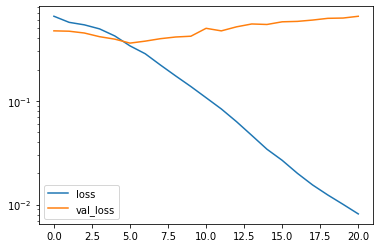

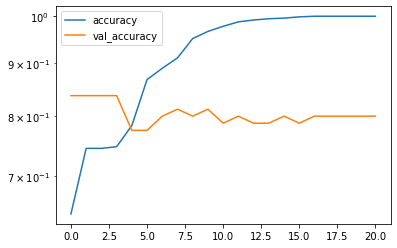

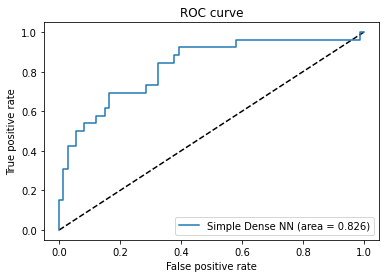

In [7]:
results[['loss','val_loss']].plot(logy=True)
results[['accuracy','val_accuracy']].plot(logy=True)
plt.show()

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_pred = model.predict([np.array(X_numerical_test).astype(float), np.array(X_categorical_test)]).ravel()
fpr, tpr, thresholds = roc_curve(np.array(Y_test), y_pred)
auc = auc(fpr, tpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Simple Dense NN (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()